<a id='setup'></a>
### Set up the environment by importing libraries
import numpy, pandas, scipy, matplotlib and other libraries to set up an environment

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix

from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point, MultiPoint
from numpy import random
from sklearn.neighbors import KDTree
import multiprocessing as mp
import geopandas as gpd

%matplotlib inline
%config InlineBackend.figure_formats = ['png']

#### LandScan Population Distribution
LandScan data is preprocessed and excluded the regions with no night-time population. Each point in this dataset represents the population aggregated to the centroid of the corresponding grid cell.

In [2]:
%%time
ls = gpd.read_file("./data/nyc_spatial_units_wspeed.shp")
ls.head(10)

Wall time: 195 ms


,Join_Count,TARGET_FID,OBJECTID,pointid,grid_code,speed_mean,pct_from_f,speed_free,geometry
0,188,1,289,289,7962,18,-28,25,POINT (-8223263.551 4994535.079)
1,155,2,1907,1907,5389,20,-24,27,POINT (-8216769.914 4963910.225)
2,94,3,1439,1439,687,26,-26,34,POINT (-8227901.863 4972475.511)
3,10,4,2629,2629,649,40,-16,47,POINT (-8262225.373 4946802.099)
4,273,5,350,350,6770,19,-25,25,POINT (-8221408.226 4993308.238)
5,84,6,1455,1455,1865,21,-26,29,POINT (-8213059.264 4972475.511)
6,224,7,1840,1840,7541,18,-27,24,POINT (-8220480.564 4965133.378)
7,118,8,1888,1888,6524,17,-31,24,POINT (-8234395.500 4963910.225)
8,197,9,2072,2072,17808,19,-34,29,POINT (-8239033.812 4960241.682)
9,80,10,1049,1049,3366,21,-21,26,POINT (-8216769.914 4979823.163)


In [3]:
ls['easting'] = ls.geometry.x
ls['northing'] = ls.geometry.y




In [25]:
# times -1 for maximizing the sum
ls['speed_pct_freeflow_rev'] = ls.pct_from_f * (-1)

total_pop = sum(ls['speed_pct_freeflow_rev'])
print("The number of records is ", len(ls))
print("The total speed unit are ", total_pop)


The number of records is  1109
The total speed unit are  28427


#### Candidate Billboard Location
Billboards data were retrieved from LAMAR

In [6]:
sitedf = pd.read_csv("./data/billboards_nyc.csv")
sites = np.array(sitedf[['POINT_X', 'POINT_Y']], dtype=np.float64)

print("The number of billboards in NYC area is ", sites.shape[0])
sitedf.head(3)

The number of billboards in NYC area is  839


,OBJECTID,FID,id,lat,long,cbsaName,cbsaGUID,plantId,tabID,panelID,panelNumbe,hoverText,heading,weeklyImpr,productTyp,POINT_X,POINT_Y
0,1,118544,683704,40.763263,-73.996509,"New York-Northern New Jersey-Long Island, NY-N...",F431156E-10EE-DD11-BFE8-001EC9ACE3EE,96453,30650812,1011873,1100,11TH AVENUE EL 50F S OF W 46TH STREET,N,218459,BULLETINS,-8237253.702,4977485.471
1,2,107366,436543,40.862150,-73.897690,"New York-Northern New Jersey-Long Island, NY-N...",F431156E-10EE-DD11-BFE8-001EC9ACE3EE,96453,480977,504228,319,GRAND CONCOURSE WL 100F S OF E FORDHAM RD,S,130209,POSTERS,-8226253.222,4992030.034
2,3,107752,437012,40.674440,-73.895780,"New York-Northern New Jersey-Long Island, NY-N...",F431156E-10EE-DD11-BFE8-001EC9ACE3EE,96453,480654,504966,653,LIBERTY AVENUE NL 100F W OF VERMONT STREET,E,36808,POSTERS,-8226040.601,4964439.587


#### Coverage of Candidate Billboards
We setup an spatial index to help counting the population covered within specified radius of the Billboards.

In [7]:
tree = KDTree(ls[['easting', 'northing']].values)

In [8]:
def billboards_covering_pop(bbs, pop, radius):
    if type(bbs) == pd.core.frame.DataFrame:
        bbs = bbs[['POINT_X', 'POINT_Y']].values
    idx = tree.query_radius(bbs, radius, count_only=False, return_distance=False)
    pop_served = [sum(pop.iloc[idx[i]]['speed_pct_freeflow_rev']) for i in range(len(bbs))]
    return pop_served

Counting the population served within 1000m of the POIs.

In [9]:
%%time
pop_covered = billboards_covering_pop(sites, ls, 2000)
sum(pop_covered)

Wall time: 318 ms


249014

#### Visualization of the input data

In [10]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])
    
    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]  
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit, 
            s=unit, horizontalalignment='left',
            verticalalignment='center')

In [11]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [12]:
sitedf1 = sitedf[sitedf['POINT_X'] < max(ls['easting'])]
sitedf1 = sitedf1[sitedf1['POINT_X'] > min(ls['easting'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] < max(ls['northing'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] > min(ls['northing'])]

Wall time: 315 ms


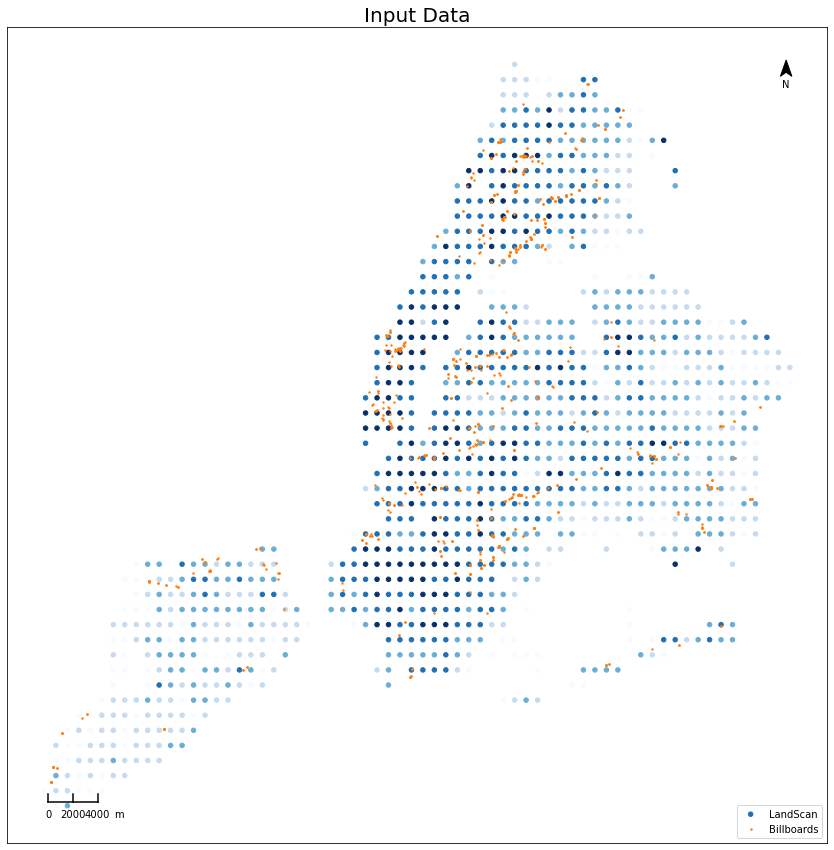

In [13]:
%%time
fig, ax = plt.subplots(figsize=(20,15))

ls.plot(ax = ax, column=ls['speed_pct_freeflow_rev'], scheme = 'natural_breaks', k=5, markersize=20, cmap='Blues', label = 'LandScan')
ax.scatter(sitedf1['POINT_X'], sitedf1['POINT_Y'], c='C1', s=2, label = 'Billboards')

ax.axis('scaled')
ax.tick_params(axis='both', left=False, top=False, right=False,
               bottom=False, labelleft=False, labeltop=False,
               labelright=False, labelbottom=False)

ax.set_title("Input Data", fontsize=20)
render_scale_bar(ax = ax, x=0.05, y=0.05)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
ax.legend(loc='lower right', markerscale = 1)

In [14]:
def distance_matrix_binary(x, y, r):
    x = np.asarray(x)
    y = np.asarray(y)
    (M, k) = x.shape
    (N, kk) = y.shape
    if k != kk:
        raise ValueError('The length of the second dimensions of x and y must be equal'
                         )
    if r < 0:
        raise ValueError('Radius must be a non-negative number.')
    mat = np.zeros((M, N), dtype=bool)
    if M < N:
        tree = KDTree(y)
        idx = tree.query_radius(x, r, count_only=False,
                                return_distance=False)
        for i in range(M):
            mat[i, idx[i]] = 1
        return mat
    else:
        tree = KDTree(x)
        idx = tree.query_radius(y, r, count_only=False,
                                return_distance=False)
        for i in range(N):
            mat[idx[i], i] = 1
        return mat

<a id='MCLP'></a>
### Solving Maximal Covering Location Problem (MCLP)

In [15]:
## GUROBI ENV
from gurobipy import *
import time

In [16]:
def generate_candidate_sites(sites, M=100, heuristic = None):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        sites: a Pandas DataFrame with X, Y and other characteristic
        M: the number of candidate sites to generate
        heuristic: 
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    if M is not None:
        if M > len(sites):
            M = None
    if heuristic is None or heuristic == '':
        if M is None:
            return sites
        index = np.random.choice(len(sites), M)
        return sites.iloc[index]
    elif heuristic == 'coverage':
        sites = sites.sort_values(by='pop_covered_2km', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'coverage_e':
        sites = sites.sort_values(by='pop_covered_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression':
        sites = sites.sort_values(by='weeklyImpr', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression_e':
        sites = sites.sort_values(by='weeklyImpr_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]

In [17]:
def mclp_landscan_ex_gurobi(ls, bbs, current_bbs, K, radius, M, heuristic=''):
    """
    Solve maximum covering location problem
    Input:
        ls: landscan dataset, Pandas DataFrame
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """

    print('----- Configurations -----')
    print('Number of points %g' % len(ls))
    print('Number of billboards %g' % len(bbs))
    print('Number of current billboards %g' % len(current_bbs))
    print('Number of selected billboards - K %g' % K)
    print('Billboard coverage Radius %g (Meter)' % radius)
    print('Number of candidate billboard sampled - M %g' % M)

    bbs_ = generate_candidate_sites(bbs, M, heuristic)
    
    #print(len(bbs_))
    current_bbs = pd.DataFrame(current_bbs, columns=['POINT_X','POINT_Y'])
    current_bbs['current'] = True
    bbs_.loc['current'] = False
    bbs = current_bbs.append(bbs_, ignore_index=True, verify_integrity=True)
    bbs = bbs.reset_index()

    J = len(bbs)  # indexing for facility sites
    I = len(ls)  # indexing for population (clients)
    D = distance_matrix_binary(ls[['easting', 'northing']].values, bbs[['POINT_X', 'POINT_Y']].values, radius)

    pop = ls['speed_pct_freeflow_rev']
    start = time.time()

    # Build model
    m = Model()

    # Add variables
    x = {}
    y = {}

    current = len(current_bbs)

    for i in range(I):
        y[i] = m.addVar(vtype=GRB.BINARY, name='y%d' % i)

    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name='x%d' % j)

    m.update()

    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for j in range(current):
        m.addConstr(x[j] == 1)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i] == 1)[0])
                    >= y[i])

    m.setObjective(quicksum(y[i] * pop[i] for i in range(I)),
                   GRB.MAXIMIZE)

    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()

    # print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x == 1 and v.varName[0] == 'x':
                solution.append(int(v.varName[1:]))

    opt_bbs = bbs.iloc[solution]
    return (opt_bbs, m.objVal)


In [18]:
ls.head(5)

,Join_Count,TARGET_FID,OBJECTID,pointid,grid_code,speed_mean,pct_from_f,speed_free,geometry,easting,northing,speed_pct_freeflow_rev
0,188,1,289,289,7962,18,-28,25,POINT (-8223263.551 4994535.079),-8.223264e+06,4.994535e+06,28
1,155,2,1907,1907,5389,20,-24,27,POINT (-8216769.914 4963910.225),-8.216770e+06,4.963910e+06,24
2,94,3,1439,1439,687,26,-26,34,POINT (-8227901.863 4972475.511),-8.227902e+06,4.972476e+06,26
3,10,4,2629,2629,649,40,-16,47,POINT (-8262225.373 4946802.099),-8.262225e+06,4.946802e+06,16
4,273,5,350,350,6770,19,-25,25,POINT (-8221408.226 4993308.238),-8.221408e+06,4.993308e+06,25


In [19]:
MCLP_STAT = pd.DataFrame({
    'Heuristic': pd.Series([], dtype='str'),
    'integrate_current_sites': pd.Series([], dtype='bool'),
    'M': pd.Series([], dtype='int'),
    'radius': pd.Series([], dtype='int'),
    'K': pd.Series([], dtype='int'),
    'coverage': pd.Series([], dtype='float64'),
    'coverage_pct': pd.Series([], dtype='float64'),
    'opt_sites': pd.Series([], dtype='object')
})

In [20]:
def plot_result(ls,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20,15))
    ls.plot(ax = ax, column=ls['speed_pct_freeflow_rev'], scheme = 'natural_breaks', k=5, markersize=1, cmap='Blues', label = 'LandScan')
    legend_plot_flag = {'current':False,'selected':False}
    
    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:#ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=1, label = 'Current Billboards')
                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=1, label = 'Optimized Selected Billboards')
                circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=100)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            ax.add_artist(circle)
        
    ax.axis('scaled')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve ' + str(radius) + ' m'
    ax.set_title(title, fontsize=20)
    render_scale_bar(ax = ax, x=0.05, y=0.05)
    render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
    ax.legend(loc='lower right', markerscale = 10)
    return ax

----- Configurations -----
Number of points 1109
Number of billboards 840
Number of current billboards 0
Number of selected billboards - K 20
Billboard coverage Radius 2000 (Meter)
Number of candidate billboard sampled - M 1109
  Running time : 0.034029245376586914 seconds
  Optimal coverage points: 7496
Wall time: 163 ms


<AxesSubplot:title={'center':'Selected 20 Sites that Serve 2000 m'}>

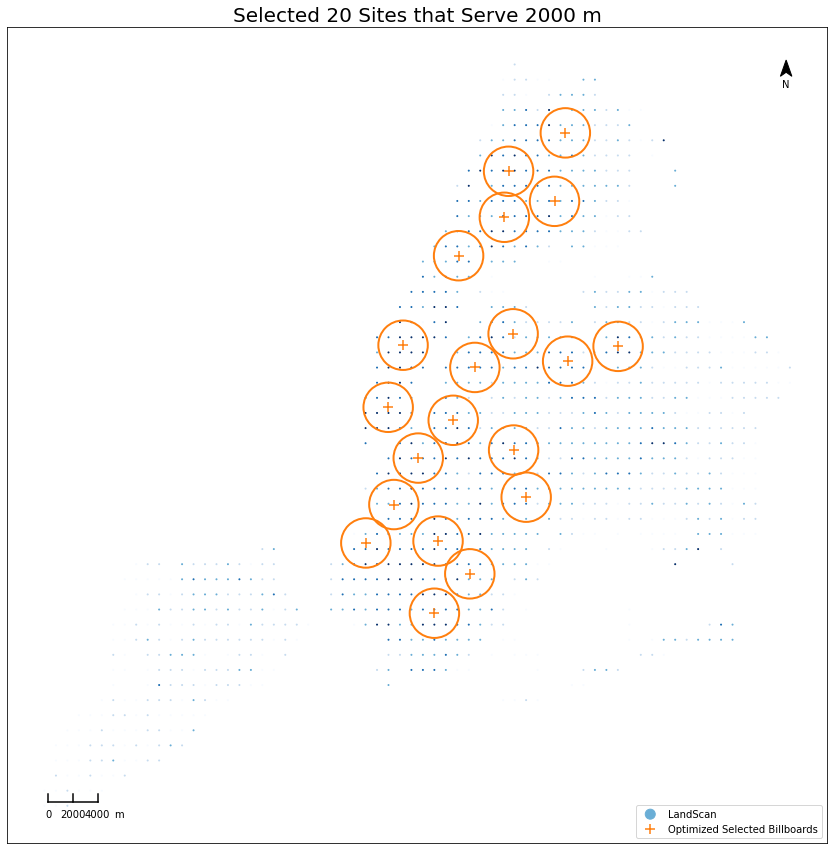

In [22]:
%%time
# Number of sites to select
K = 20

# Service radius of each site
radius = 2000

# Heuristic
heuristic = ''

# Candidate site size (random sites generated)
M = len(ls)

current_sites = []

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,n_coverage = mclp_landscan_ex_gurobi(ls, sitedf, current_sites, K, radius, M, heuristic)

#print("Total population:", total_pop, '\nCovered Population:', n_coverage , '\nCovering Ratio:', n_coverage/total_pop*100, '%')

MCLP_STAT = MCLP_STAT.append({
    'Heuristic': heuristic,
    'integrate_current_sites':True,
    'M': M,
    'radius': radius,
    'K': K,
    'coverage': n_coverage,
    'opt_sites': opt_sites
}, ignore_index = True)

plot_result(ls,opt_sites,radius)

In [23]:
#opt_sites.head(5)

jsonStr = opt_sites[['index','lat','long','heading','productTyp','weeklyImpr']].to_json()


print(jsonStr)

{"index":{"2":2,"45":45,"136":136,"154":154,"191":191,"226":226,"308":308,"324":324,"352":352,"372":372,"375":375,"382":382,"429":429,"472":472,"550":550,"636":636,"652":652,"687":687,"696":696,"739":739},"lat":{"2":40.67444,"45":40.72396,"136":40.632181,"154":40.76443,"191":40.80738,"226":40.65025,"308":40.7168,"324":40.610454,"352":40.837298,"372":40.74591,"375":40.75751,"382":40.6492,"429":40.758138,"472":40.828522,"550":40.700422,"636":40.87492,"652":40.74935,"687":40.85381,"696":40.67038,"739":40.69599},"long":{"2":-73.89578,"45":-73.996069,"136":-73.936756,"154":-73.90527,"191":-73.94489,"226":-73.95983,"308":-73.9488,"324":-73.962469,"352":-73.875171,"372":-73.93307,"375":-73.828987,"382":-74.0123,"429":-73.985243,"472":-73.911644,"550":-73.904911,"636":-73.86732,"652":-73.86565,"687":-73.90857,"696":-73.99192,"739":-73.97421},"heading":{"2":"E","45":"W","136":"W","154":"E","191":"SW","226":"E","308":"SW","324":"N","352":"NE","372":"E","375":"N","382":"S","429":"W","472":"N","55

----- Configurations -----
Number of points 1109
Number of billboards 840
Number of current billboards 0
Number of selected billboards - K 15
Billboard coverage Radius 3000 (Meter)
Number of candidate billboard sampled - M 1109
  Running time : 0.06055259704589844 seconds
  Optimal coverage points: 11326
Total population: 28427 
Covered Population: 11326.0 
Covering Ratio: 39.84240334892883 %
Wall time: 180 ms


<AxesSubplot:title={'center':'Selected 15 Sites that Serve 3000 m'}>

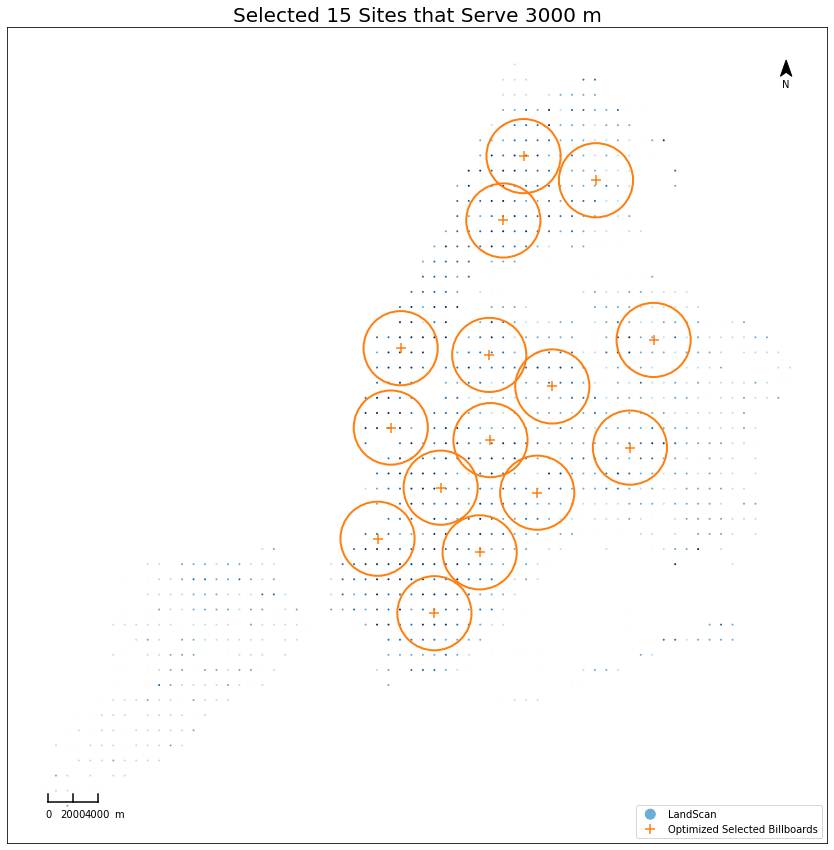

In [26]:
%%time
# Number of sites to select
K = 15

# Service radius of each site
radius = 3000

# Heuristic
heuristic = ''

# Candidate site size (random sites generated)
M = len(ls)

current_sites = []

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,n_coverage = mclp_landscan_ex_gurobi(ls, sitedf, current_sites, K, radius, M, heuristic)

print("Total population:", total_pop, '\nCovered Population:', n_coverage , '\nCovering Ratio:', n_coverage/total_pop*100, '%')

MCLP_STAT = MCLP_STAT.append({
    'Heuristic': heuristic,
    'integrate_current_sites':True,
    'M': M,
    'radius': radius,
    'K': K,
    'coverage': n_coverage,
    'coverage_pct': n_coverage/total_pop*100,
    'opt_sites': opt_sites
}, ignore_index = True)

plot_result(ls,opt_sites,radius)